# HETDEX Source Catalog 1: Catalog description and access

In [1]:
# Required python moduldes for opening FITS files and plotting
import numpy as np
import os.path as op
import glob

import matplotlib.pyplot as plt
from matplotlib import gridspec

from astropy.io import fits
from astropy.table import Table, hstack
import astropy.units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

from astropy.visualization import make_lupton_rgb, ZScaleInterval

In [2]:
%matplotlib inline

In [3]:
# fill in the path to the HETDEX Source Catalog 1 files

path_to_sc1 = "/home/jovyan/Hobby-Eberly-Public/HETDEX/catalogs/hetdex_source_catalog_1"

version = 'v3.2' # Change to latest version.

## Catalog Organization

Two catalogs make up HETDEX Source Catalog 1:
    
    1. The Source Observation Table: hetdex_sc1_vX.dat/.fits/.ecsv
       With SPECTRA arrays included: hetdex_sc1_spec_vX.fits
       
        One row per source observation. The table provides basic coordinates/redshift/source information for each observation of a unique astornomical source. The larger file hetdex_sc1_spec_vX.fits contains the same info from the first table plus addition data units of spectral array data.
        
    2. The Detection Information Table: hetdex_sc1_detinfo_vX.fits
        One row per line or continuum detection. Bright sources can be comprised of multiple line or continuum emission. This catalog provides specific detection information such as line parameter info (S/N, line flux, line width), observational data and instrument details.

## How to Open the Source Observation Table without Spectra

Multiple formats are provided for the source table. As suggested by Astropy v5.1 developers, we provide the recommended .ecsv format which contains data masking, description and quantity info. We also provide a simple .dat ascii file.

In [4]:
source_table = Table.read(op.join( path_to_sc1, 'hetdex_sc1_{}.ecsv'.format(version) ) )                       

In [5]:
# Column Info
source_table.info

<Table length=232650>
     name      dtype          unit                                       description                                 n_bad 
------------- ------- ------------------- -------------------------------------------------------------------------- ------
  source_name   str26                                                                         HETDEX IAU designation      0
    source_id   int64                                                                       HETDEX Source Identifier      0
       shotid   int64                                             integer represent observation ID: int( date+obsid)      0
           RA float32                 deg                                       source_id right ascension (ICRS deg)      0
          DEC float32                 deg                                           source_id declination (ICRS deg)      0
         gmag float32                                                   sdss-g magnitude measured in HETDEX sp

## How to Open the Source Observation Table with Spectra

If spectral data is desired, a fits file contains spectral array data matching each row of the Source Observation Table

In [6]:
hdu = fits.open( op.join( path_to_sc1, 'hetdex_sc1_spec_{}.fits'.format(version)))

In [7]:
# The source table can also be accessed by astropy Table class or through HDU1
#source_table = Table.read( op.join( path_to_sc1, 'hetdex_sc1_spec_{}.fits'.format(version)))

In [8]:
hdu.info()

Filename: /home/jovyan/Hobby-Eberly-Public/HETDEX/catalogs/hetdex_source_catalog_1/hetdex_sc1_spec_v3.2.fits
No.    Name      Ver    Type      Cards   Dimensions   Format
  0  PRIMARY       1 PrimaryHDU       4   ()      
  1  INFO          1 BinTableHDU     88   232650R x 30C   [26A, K, K, E, E, E, E, E, 8A, E, 4A, K, K, 12A, E, E, K, E, E, E, D, D, D, D, E, E, E, E, E, E]   
  2  SPEC          1 ImageHDU        10   (1036, 232650)   float32   
  3  SPEC_ERR      1 ImageHDU         9   (1036, 232650)   float32   
  4  SPEC_OBS      1 ImageHDU        10   (1036, 232650)   float32   
  5  SPEC_OBS_ERR    1 ImageHDU         9   (1036, 232650)   float32   
  6  APCOR         1 ImageHDU         8   (1036, 232650)   float32   
  7  WAVELENGTH    1 ImageHDU         8   (1036,)   float64   


In [9]:
spec = hdu['SPEC'].data
spec_err = hdu['SPEC_ERR'].data
wave_rect = hdu['WAVELENGTH'].data

In [10]:
#spec unit is:
u.Unit( hdu['SPEC'].header['BUNIT'])

Unit("1e-17 erg / (Angstrom cm2 s)")

In [11]:
# wavelength unit is:
u.Unit( hdu['WAVELENGTH'].header['BUNIT'])

Unit("Angstrom")

### Query by source type example

In [12]:
sel_lae = source_table['source_type'] == 'lae'
print('There are {} LAES in the catalog'.format(np.sum(sel_lae)))

There are 52681 LAES in the catalog


In [13]:
source_ids_lae = source_table['source_id'][sel_lae]

In [14]:
# Plot of all LAE spectra in redshift order as an example
lae_spec_table = hstack( [source_table[sel_lae], spec[sel_lae], spec_err[sel_lae]])

In [15]:
lae_spec_table.rename_column('col0_2', 'spec')
lae_spec_table.rename_column('col0_3', 'spec_err')

In [16]:
lae_spec_table.sort('z_hetdex')

Text(0, 0.5, 'HETDEX 1D LAE spectra')

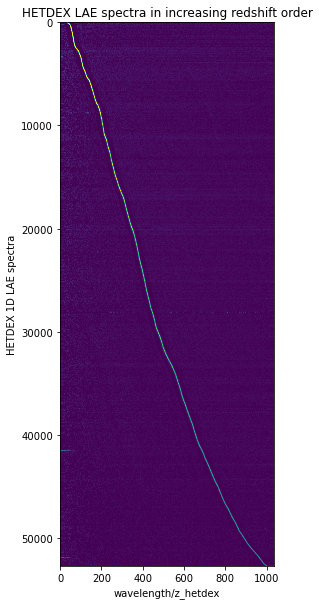

In [17]:
plt.figure(figsize=(4, 10))
plt.imshow( lae_spec_table['spec'], aspect=0.05, vmin=-0.01, vmax=2)
plt.title('HETDEX LAE spectra in increasing redshift order')
plt.xlabel('wavelength/z_hetdex')
plt.ylabel('HETDEX 1D LAE spectra')

### Query by Sky Coordinate Example

In [18]:
# Create array of coordinates for all HETDEX source members
source_coords = SkyCoord(ra = source_table['RA'], dec= source_table['DEC'])

In [19]:
coord = SkyCoord(ra=220.21432*u.deg, dec=52.095898*u.deg)

In [20]:
sel_match = source_coords.separation(coord) < 1.*u.arcsec

### Access and Plot Spectra

Text(0.5, 1.0, 'HETDEX J144051.44+520545.2  source_id=2140100250906')

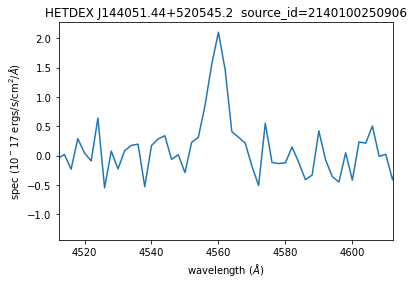

In [21]:
redshift = source_table['z_hetdex'][sel_match][0]

lya_wave = 1216* (redshift + 1)
source_id = source_table['source_id'][sel_match][0]
name = source_table['source_name'][sel_match][0]
plt.plot( wave_rect, spec[sel_match][0])

plt.xlim(lya_wave-50, lya_wave+50)
plt.ylabel(r'spec (10$^-17$ ergs/s/cm$^2$/$\AA$)')
plt.xlabel(r'wavelength ($\AA$)')
plt.title('{}  source_id={}'.format(name, source_id))

## How to Open the Detection Info Table

In [22]:
det_table = Table.read(op.join(path_to_sc1, 'hetdex_sc1_detinfo_{}.ecsv'.format(version)))

In [23]:
# Column Info
det_table.info

<Table length=297261>
          name            dtype              unit                                               description                                   n_bad 
------------------------ ------- ---------------------------- ------------------------------------------------------------------------------- ------
               source_id   int64                                                                                     HETDEX Source Identifier      0
             source_name   str26                                                                                       HETDEX IAU designation      0
                      RA float32                          deg                                            source_id right ascension (ICRS deg)      0
                     DEC float32                          deg                                                source_id declination (ICRS deg)      0
                z_hetdex float32                                                    

### Plot up all detections for a single source_id

Let's query the detection info table for a relatively nearby, bright galaxy that is composed of serveral line detections to demonstrate the content of the Detection Info Table. Nearby galaxies and bright sources such as AGN can be composed of many detections. This is because line emission at different spatial regions and wavelengths will result in multiple detections in the detection search. The source will also likely have a complementary continuum detetion if it is bright (g < 21)

In [24]:
sel_big_oii = (det_table['source_type'] == 'oii') & (det_table['major'] > 6) 
sel_center_ifu = (np.abs( det_table['x_ifu']) < 5) & (np.abs(det_table['y_ifu']) < 5)
selected_det = (det_table['selected_det'] == True) & (det_table['n_members'] >6)

In [25]:
sel = sel_big_oii & sel_center_ifu & selected_det

print(' There are {} matches '.format(np.sum(sel)))

 There are 79 matches 


In [26]:
# Pick random object in list and plot up the source_id

index = np.where(sel)[0][0]

sid = det_table['source_id'][index]
 
coords = SkyCoord(ra=det_table['RA'][index]*u.deg, dec=det_table['DEC'][index]*u.deg)

In [27]:
# Get Imaging data from Legacy Survey API
fits_file = 'https://www.legacysurvey.org/viewer/fits-cutout?ra={}&dec={}&layer=ls-dr9&width=80&height=80&pixscale=0.25&bands=grz'.format(coords.ra.deg, coords.dec.deg)
hdu_ls = fits.open(fits_file)
wcs_ls = WCS( hdu_ls[0].header).dropaxis(2)


In [28]:
redshift = det_table['z_hetdex'][index]
source_type = det_table['source_type'][index]

grp = det_table[ det_table['source_id'] == sid]
grp.sort('gmag')

In [29]:
# Get Spectrum from source_table
hdu = fits.open(op.join(path_to_sc1, 'hetdex_sc1_spec_{}.fits'.format(version)))
source_table = hdu['INFO'].data
spec = hdu['SPEC'].data
sel_source = source_table['source_id'] == sid
spectra = spec[sel_source][0]

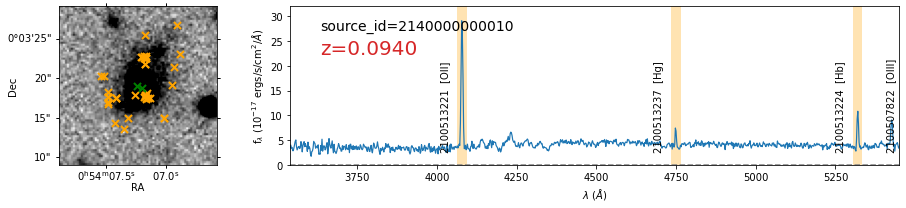

In [30]:
plt.figure(figsize=(13,3))
gs = gridspec.GridSpec(1, 2, width_ratios=[1,3]) 

ax1 = plt.subplot(gs[0], projection=wcs_ls)
im_zscale = ZScaleInterval(contrast=0.5, krej=1.1)
im_vmin, im_vmax = im_zscale.get_limits(values=hdu_ls[0].data[2])
plt.imshow(hdu_ls[0].data[2], origin='lower', cmap=plt.get_cmap('gray_r'), vmin=im_vmin, vmax=im_vmax  )

sel_line = (grp["det_type"] == "line")
if np.sum(sel_line) >= 1:
    plt.scatter(
        grp["RA_det"][sel_line],
        grp["DEC_det"][sel_line],
        transform=ax1.get_transform("world"),
        marker="x",
        color="orange",
        linewidth=2,
        s=50,
#        zorder=100,
        label="line emission",
    )

sel_cont = grp["det_type"] == "cont"
if np.sum(sel_cont) >= 1:
    plt.scatter(
        grp["RA_det"][sel_cont],
        grp["DEC_det"][sel_cont],
        transform=ax1.get_transform("world"),
        marker="x",
        color="green",
        linewidth=2,
        s=50,
        label="continuum",
    )
lon = ax1.coords[0]
lat = ax1.coords[1]
lon.set_axislabel('RA', minpad=0.5)
lat.set_axislabel('Dec', minpad=-0.6)
lon.set_ticklabel(exclude_overlapping=True)
    
ax2 = plt.subplot(gs[1])

plt.plot(wave_rect, spectra, linewidth=1.2, color='tab:blue')#, yerr=spec_table['spec1d_err'])
plt.xlabel(r'$\lambda$ ($\AA$)')
plt.ylabel('f$_\\lambda$ (10$^{-17}$ ergs/s/cm$^2$/$\AA$)')
plt.xlim(3540, 5450)

selw = (wave_rect > 3540) & (wave_rect < 5450)
y2 = np.max(spectra[selw])
y1 = np.min(spectra[selw])

if y1 > 0:
    y1 = 0

# plot all emission lines detected in det_table related to the source_id

for line in np.array( np.unique(grp['line_id'])):
    if line == 'null':
        continue
    
    sel_line = grp['line_id'] == line   

    plt.bar(grp['wave'][sel_line][0], height=2*y2, width=30, bottom=y1, color='orange', alpha=0.3)
    
    label = '{}  [{}]'.format( grp['detectid'][sel_line][0], line)
    if np.isfinite( grp['wave'][sel_line][0]):
        plt.text(grp['wave'][sel_line][0]-70, 0.1*y2, label, rotation=90, fontsize=10)

plt.axhline(0, color='tab:grey', linestyle='dashed')
plt.text(0.05, 0.7, 'z={:6.4f}'.format(redshift), transform=ax2.transAxes, color='tab:red', fontsize=20)
plt.text(0.05, 0.85, 'source_id={}'.format(sid), transform=ax2.transAxes, fontsize=14, color='black')
plt.ylim(y1,1.1*y2)
plt.subplots_adjust(wspace=0.3, hspace=0)
plt.tight_layout()

# References

* Dey, A., Schlegel, D.J., Lang, D., et al. 2019, Astrophysical Journal, 157, 168. doi:10.3847/1538-3881/ab089d LEGACY SURVEY: we use the LS API to obtain a sky cutout at the HETDEX source
https://www.legacysurvey.org. 
* Gebhardt, K., Mentuch Cooper, E., Ciardullo, R., et al. 2021, Astrophysical Journal, 923, 217. doi:10.3847/1538-4357/ac2e03
